In [107]:
SPAM_1_PATH = 'SpamData/01_Processing/spam_assassin_corpus/spam_1'
SPAM_2_PATH = 'SpamData/01_Processing/spam_assassin_corpus/spam_2'
EASY_NONSPAM_1_PATH = 'SpamData/01_Processing/spam_assassin_corpus/easy_ham_1'
EASY_NONSPAM_2_PATH = 'SpamData/01_Processing/spam_assassin_corpus/easy_ham_2'
EXAMPLE_FILE = 'SpamData/01_Processing/practice_email.txt'
SPAM_CAT = 1
HAM_CAT =0
VOCAB_SIZE = 2500

WHALE_FILE = 'SpamData/01_Processing/wordcloud_resources/whale-icon.png'
SKULL_FILE = 'SpamData/01_Processing/wordcloud_resources/skull-icon.png'

THUMBS_UP_FILE = 'SpamData/01_Processing/wordcloud_resources/thumbs-up.png'
THUMBS_DOWN_FILE = 'SpamData/01_Processing/wordcloud_resources/thumbs-down.png'

DATA_JSON_FILE = 'SpamData/01_Processing/email-text-data.json'
WORD_ID_FILE = 'SpamData/01_Processing/word-by-id.csv'
TRAINING_DATA_FILE = 'SpamData/02_Training/train-data.txt'
TEST_DATA_FILE = 'SpamData/02_Training/test-data.txt'

In [4]:
import pandas as pd
import numpy as np

In [5]:
from os import walk
from os.path import join

import matplotlib.pyplot as plt

import nltk
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from PIL import Image

from bs4 import BeautifulSoup
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split

%matplotlib inline

In [6]:
stream = open(EXAMPLE_FILE, encoding='latin-1')

lines = []
is_body = False

for line in stream:
    if is_body:
        lines.append(line)
    elif line == '\n':
        is_body = True

stream.close()

email_body = '\n'.join(lines)

print(email_body)



Dear Mr Still



Good tidings to you and all your staff for the festive season ahead (Christmas).

Now to the crux of the matter-in-hand: I am a fully qualified Santa Claus and am wondering whether you might consider me to run my own "Santa's Grotto" in your store.

But WAIT! You're probably thinking: "What makes him so special?"

Well, first of all, I have made several changes to the characterisation of Father Christmas. Rather than greeting the children with shouts of "Ho, ho, ho!" I prefer to whisper the phrase "Dependence is not unfathomable in this cruel world we live in". In addition, my gifts are ALL hand-made, ranging from felt hoops to vanilla-pod holders.

You will note also, from the enclosed sketch, that I have radically redesigned Santa's outfit and have renamed my character "Lord Buckles". Would you be interested in employing me? I promise NEVER to let you down.

I look forward to hearing from you.



Best wishes

Robin Cooper

[Excerpt from the book: The Timewaster Let

Now we need to do it extract the same from the Datasets - Generative function:

In [7]:
def generative_function(N):
    for my_number in range(N):
        yield my_number**2


In [8]:
for i in generative_function(5):
    print(i , end=' -> ')

0 -> 1 -> 4 -> 9 -> 16 -> 

Email body extraction

In [9]:
def email_body_generator(path):
    
    for root, dirname , filenames in walk(path):
        for file_name in filenames:
            
            filepath = join(root, file_name) #  combined the path of root directory with a filename
            
            stream = open(filepath, encoding='latin-1')

            lines = []
            is_body = False

            for line in stream:
                if is_body:
                    lines.append(line)
                elif line == '\n':
                    is_body = True

            stream.close()
            email_body = '\n'.join(lines) 

            yield file_name, email_body

In [10]:
def df_from_directory(path, classification):
    rows=[]
    row_names=[]
    
    for file_name , email_body in email_body_generator(path):
        rows.append({'MESSAGE': email_body,'CATEGORY' : classification})
        row_names.append(file_name)
        
    return pd.DataFrame(rows, index=row_names)

In [11]:

spam_emails_1 = df_from_directory(SPAM_1_PATH,SPAM_CAT)
spam_emails_2 = df_from_directory(SPAM_2_PATH,SPAM_CAT)
spam_emails = pd.concat([spam_emails_1, spam_emails_2])
spam_emails.head()

,MESSAGE,CATEGORY
00001.7848dde101aa985090474a91ec93fcf0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1
00002.d94f1b97e48ed3b553b3508d116e6a09,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
00003.2ee33bc6eacdb11f38d052c44819ba6c,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
00004.eac8de8d759b7e74154f142194282724,##############################################...,1
00005.57696a39d7d84318ce497886896bf90d,I thought you might like these:\n\n1) Slim Dow...,1


In [12]:
spam_emails.shape

(1898, 2)

In [13]:
ham_emails_1 = df_from_directory(EASY_NONSPAM_1_PATH,HAM_CAT)
ham_emails_2 = df_from_directory(EASY_NONSPAM_2_PATH,HAM_CAT)
ham_emails = pd.concat([ham_emails_1, ham_emails_1])
ham_emails.head()

,MESSAGE,CATEGORY
00001.7c53336b37003a9286aba55d2945844c,"Date: Wed, 21 Aug 2002 10:54:46 -05...",0
00002.9c4069e25e1ef370c078db7ee85ff9ac,"Martin A posted:\n\nTassos Papadopoulos, the G...",0
00003.860e3c3cee1b42ead714c5c874fe25f7,Man Threatens Explosion In Moscow \n\n\n\nThur...,0
00004.864220c5b6930b209cc287c361c99af1,Klez: The Virus That Won't Die\n\n \n\nAlready...,0
00005.bf27cdeaf0b8c4647ecd61b1d09da613,"> in adding cream to spaghetti carbonara, whi...",0


In [14]:
ham_emails.shape

(5002, 2)

In [15]:
data = pd.concat([spam_emails, ham_emails])
print('shape of entire dataframe is ', data.shape)
data.tail()

shape of entire dataframe is  (6900, 2)


,MESSAGE,CATEGORY
02497.60497db0a06c2132ec2374b2898084d3,"Hi Gianni,\n\n\n\nA very good resource for thi...",0
02498.09835f512f156da210efb99fcc523e21,Gianni Ponzi wrote:\n\n> I have a prob when tr...,0
02499.b4af165650f138b10f9941f6cc5bce3c,Neale Pickett <neale@woozle.org> writes:\n\n\n...,0
02500.05b3496ce7bca306bed0805425ec8621,"\n\nHi,\n\n\n\nI think you need to give us a l...",0
cmds,,0


Cleaning Data : Checking for missing values

In [16]:
# check if any message are null
data['MESSAGE'].isnull().values.any()

False

In [17]:
#check if any empty email (string length is zero)
(data.MESSAGE.str.len() == 0).any()

True

In [18]:
(data.MESSAGE.str.len() == 0).sum()

4

Locate empty emails

In [19]:
type((data.MESSAGE.str.len() == 0))

pandas.core.series.Series

In [20]:
unwanted_rows = data[data.MESSAGE.str.len() == 0].index

Remove system files from data file

In [21]:
data = data.drop(unwanted_rows)

Add Document ID to Track Email in Dataset

In [22]:
document_id = range(0,len(data.index))
data['DOC_ID'] = document_id
data.tail()


,MESSAGE,CATEGORY,DOC_ID
02496.aae0c81581895acfe65323f344340856,Man killed 'trying to surf' on Tube train \n\n...,0,6891
02497.60497db0a06c2132ec2374b2898084d3,"Hi Gianni,\n\n\n\nA very good resource for thi...",0,6892
02498.09835f512f156da210efb99fcc523e21,Gianni Ponzi wrote:\n\n> I have a prob when tr...,0,6893
02499.b4af165650f138b10f9941f6cc5bce3c,Neale Pickett <neale@woozle.org> writes:\n\n\n...,0,6894
02500.05b3496ce7bca306bed0805425ec8621,"\n\nHi,\n\n\n\nI think you need to give us a l...",0,6895


In [23]:
data['FILE_NAME'] = data.index
data.set_index('DOC_ID', inplace=True)


In [24]:
data.tail()

,MESSAGE,CATEGORY,FILE_NAME
DOC_ID,,,
6891,Man killed 'trying to surf' on Tube train \n\n...,0,02496.aae0c81581895acfe65323f344340856
6892,"Hi Gianni,\n\n\n\nA very good resource for thi...",0,02497.60497db0a06c2132ec2374b2898084d3
6893,Gianni Ponzi wrote:\n\n> I have a prob when tr...,0,02498.09835f512f156da210efb99fcc523e21
6894,Neale Pickett <neale@woozle.org> writes:\n\n\n...,0,02499.b4af165650f138b10f9941f6cc5bce3c
6895,"\n\nHi,\n\n\n\nI think you need to give us a l...",0,02500.05b3496ce7bca306bed0805425ec8621


Save to FIle using Pandas

In [25]:
data.to_json(DATA_JSON_FILE)   

Number of spam messages visualized (pie charts)

In [26]:
data.CATEGORY.value_counts()

CATEGORY
0    5000
1    1896
Name: count, dtype: int64

In [27]:
amount_of_spam = data.CATEGORY.value_counts()[1]
amount_of_ham = data.CATEGORY.value_counts()[0]

<function matplotlib.pyplot.show(close=None, block=None)>

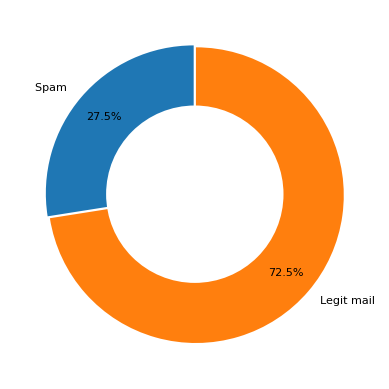

In [28]:
category_names = ['Spam ' , 'Legit mail']
sizes = [amount_of_spam, amount_of_ham]
#plt.figure(figure=(2,2) , dpi=227)
plt.pie(sizes, labels=category_names , textprops={'fontsize' : 8} , startangle=90 , autopct='%1.1f%%' , explode=[0.01,0.01] , pctdistance=0.8)

#draw circle
centre_circle = plt.Circle((0,0) , radius=0.6 , fc='white')
plt.gca().add_artist(centre_circle)
plt.show

Natural Language Processing

In [29]:
#covert to text to lower case
msg = 'All work and no play makes Jack a dull boy.'
msg.lower()

'all work and no play makes jack a dull boy.'

Download NLTK Resources (Tokenizer and Stopwords)

In [30]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jasee\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [31]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jasee\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [32]:
nltk.download('gutenberg')
nltk.download('shakespeare')

[nltk_data] Downloading package gutenberg to
[nltk_data]     C:\Users\jasee\AppData\Roaming\nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package shakespeare to
[nltk_data]     C:\Users\jasee\AppData\Roaming\nltk_data...
[nltk_data]   Package shakespeare is already up-to-date!


True

Tokenising

In [33]:
word_tokenize(msg.lower())

['all', 'work', 'and', 'no', 'play', 'makes', 'jack', 'a', 'dull', 'boy', '.']

Removing stopwords

In [34]:
stop_words = set(stopwords.words('english'))
type(stop_words)


set

In [35]:
if '.' in stop_words: print('not found it')

In [36]:
msg = 'All work and no play makes Jack a dull boy. To be or not to be.'
words = word_tokenize(msg.lower())

filtered_words =[]
for word in words:
    if word not in stop_words:
        filtered_words.append(word)
filtered_words        

['work', 'play', 'makes', 'jack', 'dull', 'boy', '.', '.']

Word Stems and Stemming 

In [37]:
msg = 'All work and no play makes Jack a dull boy. To be or not to be. \
    Nobody expects the Spanish Inquisitions!.'
words = word_tokenize(msg.lower())
#stemmer = PorterStemmer()
stemmer = SnowballStemmer('english')

filtered_words =[]
for word in words:
    if word not in stop_words:
        stemmed_word = stemmer.stem(word)
        filtered_words.append(stemmed_word)
print(filtered_words)        

['work', 'play', 'make', 'jack', 'dull', 'boy', '.', '.', 'nobodi', 'expect', 'spanish', 'inquisit', '!', '.']


Removing Puctuations

In [38]:
msg = 'All work and no play makes Jack a dull boy. To be or not to be. \
    Nobody expects the Spanish Inquisitions!.'
words = word_tokenize(msg.lower())
stemmer = SnowballStemmer('english')

filtered_words =[]
for word in words:
    if word not in stop_words and word.isalpha():
        stemmed_word = stemmer.stem(word)
        filtered_words.append(stemmed_word)
print(filtered_words)        

['work', 'play', 'make', 'jack', 'dull', 'boy', 'nobodi', 'expect', 'spanish', 'inquisit']


Removing HTML tag from Emails

In [39]:
soup = BeautifulSoup(data.at[2,'MESSAGE'], 'html.parser')
print(soup.prettify())

1) Fight The Risk of Cancer!

http://www.adclick.ws/p.cfm?o=315&amp;s=pk007



2) Slim Down - Guaranteed to lose 10-12 lbs in 30 days

http://www.adclick.ws/p.cfm?o=249&amp;s=pk007



3) Get the Child Support You Deserve - Free Legal Advice

http://www.adclick.ws/p.cfm?o=245&amp;s=pk002



4) Join the Web's Fastest Growing Singles Community

http://www.adclick.ws/p.cfm?o=259&amp;s=pk007



5) Start Your Private Photo Album Online!

http://www.adclick.ws/p.cfm?o=283&amp;s=pk007



Have a Wonderful Day,

Offer Manager

PrizeMama



























If you wish to leave this list please use the link below.

http://www.qves.com/trim/?zzzz@spamassassin.taint.org%7C17%7C308417



In [40]:
print(soup.prettify())

1) Fight The Risk of Cancer!

http://www.adclick.ws/p.cfm?o=315&amp;s=pk007



2) Slim Down - Guaranteed to lose 10-12 lbs in 30 days

http://www.adclick.ws/p.cfm?o=249&amp;s=pk007



3) Get the Child Support You Deserve - Free Legal Advice

http://www.adclick.ws/p.cfm?o=245&amp;s=pk002



4) Join the Web's Fastest Growing Singles Community

http://www.adclick.ws/p.cfm?o=259&amp;s=pk007



5) Start Your Private Photo Album Online!

http://www.adclick.ws/p.cfm?o=283&amp;s=pk007



Have a Wonderful Day,

Offer Manager

PrizeMama



























If you wish to leave this list please use the link below.

http://www.qves.com/trim/?zzzz@spamassassin.taint.org%7C17%7C308417



Functions for email processing

In [41]:
def clean_message(message, stemmer = PorterStemmer(),
                  stop_words=set(stopwords.words('english'))):
    filtered_words=[]
    # converts to lower case and split the message
    words = word_tokenize(message.lower())
    
    for word in words:
        # Remove stopwords and remove punctuations
        if word not in stop_words and word.isalpha():
            filtered_words.append(stemmer.stem(word))  
    return filtered_words

In [42]:
clean_message(data.at[0,'MESSAGE'])

['doctyp',
 'html',
 'public',
 'html',
 'html',
 'head',
 'meta',
 'ype',
 'meta',
 'mshtml',
 'bodi',
 'insert',
 'calypso',
 'tabl',
 'color',
 'black',
 'display',
 'none',
 'tbodi',
 'tr',
 'td',
 'hr',
 'noshad',
 'tr',
 'td',
 'hr',
 'noshad',
 'end',
 'calypso',
 'insert',
 'font',
 'arial',
 'helvetica',
 'br',
 'end',
 'calypso',
 'font',
 'copperpl',
 'gothic',
 'bold',
 'center',
 'save',
 'life',
 'font',
 'copperpl',
 'gothic',
 'bold',
 'center',
 'spend',
 'center',
 'font',
 'copperpl',
 'gothic',
 'bold',
 'center',
 'life',
 'quot',
 'save',
 'center',
 'p',
 'p',
 'br',
 'p',
 'center',
 'tabl',
 'tbodi',
 'tabl',
 'tbodi',
 'tr',
 'td',
 'b',
 'font',
 'g',
 'famili',
 'financi',
 'secur',
 'import',
 'life',
 'quot',
 'save',
 'ke',
 'buy',
 'life',
 'insur',
 'simpl',
 'afford',
 'provid',
 'free',
 'access',
 'best',
 'compani',
 'lowest',
 'tr',
 'td',
 'tabl',
 'tbodi',
 'tr',
 'td',
 'font',
 'b',
 'life',
 'quot',
 'save',
 'fast',
 'save',
 'money',
 'let',

In [1]:
def clean_message_no_html(message, stemmer = PorterStemmer(),
                  stop_words=set(stopwords.words('english'))):
    filtered_words=[]
    #Remove HTML tags
    soup = BeautifulSoup(message, 'html.parser')
    cleaned_text = soup.get_text()
    # converts to lower case and split the message
    words = word_tokenize(cleaned_text.lower())
    
    for word in words:
        # Remove stopwords and remove punctuations
        if word not in stop_words and word.isalpha():
            filtered_words.append(stemmer.stem(word))  
    return filtered_words

NameError: name 'PorterStemmer' is not defined

In [44]:
clean_message_no_html(data.at[0,'MESSAGE'])

['save',
 'life',
 'insur',
 'spend',
 'life',
 'quot',
 'save',
 'g',
 'famili',
 'financi',
 'secur',
 'import',
 'life',
 'quot',
 'save',
 'ke',
 'buy',
 'life',
 'insur',
 'simpl',
 'afford',
 'provid',
 'free',
 'access',
 'best',
 'compani',
 'lowest',
 'rate',
 'life',
 'quot',
 'save',
 'fast',
 'save',
 'money',
 'let',
 'us',
 'help',
 'get',
 'start',
 'best',
 'ue',
 'countri',
 'new',
 'coverag',
 'save',
 'hundr',
 'even',
 'usand',
 'dollar',
 'request',
 'free',
 'quot',
 'lifequot',
 'save',
 'servic',
 'take',
 'less',
 'minut',
 'complet',
 'shop',
 'compar',
 'save',
 'type',
 'life',
 'insur',
 'click',
 'free',
 'quot',
 'protect',
 'famili',
 'best',
 'invest',
 'r',
 'make',
 'receipt',
 'email',
 'error',
 'wish',
 'remov',
 'list',
 'pleas',
 'click',
 'type',
 'remov',
 'resid',
 'state',
 'prohibit',
 'solicit',
 'ce',
 'pleas',
 'disregard',
 'email']

# Apply Cleaning and Tokenisation to all messages

### Slicing Dataframes and Series & Creating Subsets

In [45]:
data.iat[0,0]

'<!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 4.0 Transitional//EN">\n\n<HTML><HEAD>\n\n<META content=3D"text/html; charset=3Dwindows-1252" http-equiv=3DContent-T=\n\nype>\n\n<META content=3D"MSHTML 5.00.2314.1000" name=3DGENERATOR></HEAD>\n\n<BODY><!-- Inserted by Calypso -->\n\n<TABLE border=3D0 cellPadding=3D0 cellSpacing=3D2 id=3D_CalyPrintHeader_ r=\n\nules=3Dnone \n\nstyle=3D"COLOR: black; DISPLAY: none" width=3D"100%">\n\n  <TBODY>\n\n  <TR>\n\n    <TD colSpan=3D3>\n\n      <HR color=3Dblack noShade SIZE=3D1>\n\n    </TD></TR></TD></TR>\n\n  <TR>\n\n    <TD colSpan=3D3>\n\n      <HR color=3Dblack noShade SIZE=3D1>\n\n    </TD></TR></TBODY></TABLE><!-- End Calypso --><!-- Inserted by Calypso=\n\n --><FONT \n\ncolor=3D#000000 face=3DVERDANA,ARIAL,HELVETICA size=3D-2><BR></FONT></TD><=\n\n/TR></TABLE><!-- End Calypso --><FONT color=3D#ff0000 \n\nface=3D"Copperplate Gothic Bold" size=3D5 PTSIZE=3D"10">\n\n<CENTER>Save up to 70% on Life Insurance.</CENTER></FONT><FONT color=3D#ff=\n\n0000

In [46]:
data.iloc[5:11]

,MESSAGE,CATEGORY,FILE_NAME
DOC_ID,,,
5,A POWERHOUSE GIFTING PROGRAM You Don't Want To...,1,00006.5ab5620d3d7c6c0db76234556a16f6c1
6,Help wanted. We are a 14 year old fortune 500...,1,00007.d8521faf753ff9ee989122f6816f87d7
7,<html>\n\n<head>\n\n<title>ReliaQuote - Save U...,1,00008.dfd941deb10f5eed78b1594b131c9266
8,TIRED OF THE BULL OUT THERE?\n\nWant To Stop L...,1,00009.027bf6e0b0c4ab34db3ce0ea4bf2edab
9,"Dear ricardo1 ,\n\n\n\n<html>\n\n<body>\n\n<ce...",1,00010.445affef4c70feec58f9198cfbc22997
10,Cellular Phone Accessories All At Below Wholes...,1,00011.61816b9ad167657773a427d890d0468e


In [47]:
first_emails= data.MESSAGE.iloc[0:3]

nested_list = first_emails.apply(clean_message)
nested_list

DOC_ID
0    [doctyp, html, public, html, html, head, meta,...
1    [fight, risk, cancer, http, slim, guarante, lo...
2    [fight, risk, cancer, http, slim, guarante, lo...
Name: MESSAGE, dtype: object

In [48]:
# flat_list =[]

# for sublist in nested_list:
#     for item in sublist:
#         flat_list.append(item)
 
flat_list =[item for sublist in nested_list for item in sublist]
        
len(flat_list)

321

In [49]:
%%time
nested_list = data.MESSAGE.apply(clean_message_no_html)

C:\Users\jasee\AppData\Local\Temp\ipykernel_1408\2089539986.py:5: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(message, 'html.parser')
C:\Users\jasee\AppData\Local\Temp\ipykernel_1408\2089539986.py:5: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  soup = BeautifulSoup(message, 'html.parser')


CPU times: total: 52 s
Wall time: 52.5 s


In [50]:
nested_list.tail()

DOC_ID
6891    [man, kill, surf, tube, train, ananova, wednes...
6892    [hi, gianni, good, resourc, http, http, walk, ...
6893    [gianni, ponzi, wrote, prob, tri, instal, linu...
6894    [neal, pickett, write, skip, montanaro, write,...
6895    [hi, think, need, give, us, littl, detail, inf...
Name: MESSAGE, dtype: object

## Using Logic to Slice DataFrames part 2

In [51]:
doc_ids_spam= data[data.CATEGORY == 1].index
doc_ids_ham= data[data.CATEGORY == 0].index
type(doc_ids_ham)
type(nested_list)


pandas.core.series.Series

Subsetting a Series with an Index

In [52]:
nested_list_ham = nested_list.loc[doc_ids_ham]
nested_list_ham.tail()

DOC_ID
6891    [man, kill, surf, tube, train, ananova, wednes...
6892    [hi, gianni, good, resourc, http, http, walk, ...
6893    [gianni, ponzi, wrote, prob, tri, instal, linu...
6894    [neal, pickett, write, skip, montanaro, write,...
6895    [hi, think, need, give, us, littl, detail, inf...
Name: MESSAGE, dtype: object

In [53]:
nested_list_spam = nested_list.loc[doc_ids_spam]

In [54]:
# use python list comprehension and then find the total
#number of words in our cleaned datasets of spam emails , also find the total number of 
#words in normal emails in the datasets . then find the 10 most common words used in spam  also same in non spam
# First try
# spam = data[data.CATEGORY == 1]
# ham = data[data.CATEGORY == 0]
# spam_message = spam['MESSAGE']
# ham_message = ham['MESSAGE']
# # nonspam = data[data.CATEGORY == 0]
# spam_words = spam_message.apply(clean_message_no_html)
# ham_words = ham_message.apply(clean_message_no_html)
flat_list_ham = [item for sublist in nested_list_ham for item in sublist]
normal_words = pd.Series(flat_list_ham).value_counts()
# to find the unique no of words
normal_words.shape[0] # just use len(flat_list_ham)
# to find the 10 most common words
normal_words[:10]




 

http      8624
use       4248
list      2772
get       2762
one       2676
mail      2476
like      2354
would     2284
messag    2182
time      2154
Name: count, dtype: int64

In [55]:
flat_list_spam = [item for sublist in nested_list_spam for item in sublist]
spammy_words = pd.Series(flat_list_spam).value_counts()
# to find the unique no of words
spammy_words.shape[0] # just use len(flat_list_ham)
# to find the 10 most common words
spammy_words[:10]

http      3097
email     3090
free      2585
click     2058
receiv    1989
list      1971
get       1914
pleas     1852
busi      1792
order     1746
Name: count, dtype: int64

Creating a Word Cloud

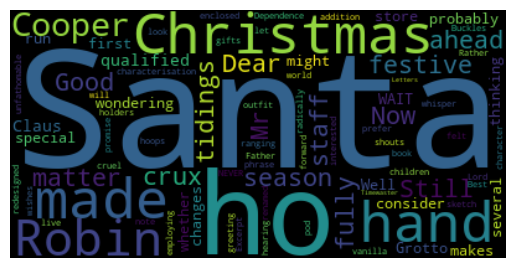

In [56]:
word_cloud = WordCloud().generate(email_body)
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [57]:
example_corpus= nltk.corpus.gutenberg.words('melville-moby_dick.txt')
len(example_corpus)
example_corpus

['[', 'Moby', 'Dick', 'by', 'Herman', 'Melville', ...]

In [58]:
type(example_corpus)

nltk.corpus.reader.util.StreamBackedCorpusView

In [59]:
word_list=[''.join(word) for word in example_corpus]
novel_as_string = ' '.join(word_list)
type(novel_as_string)

str

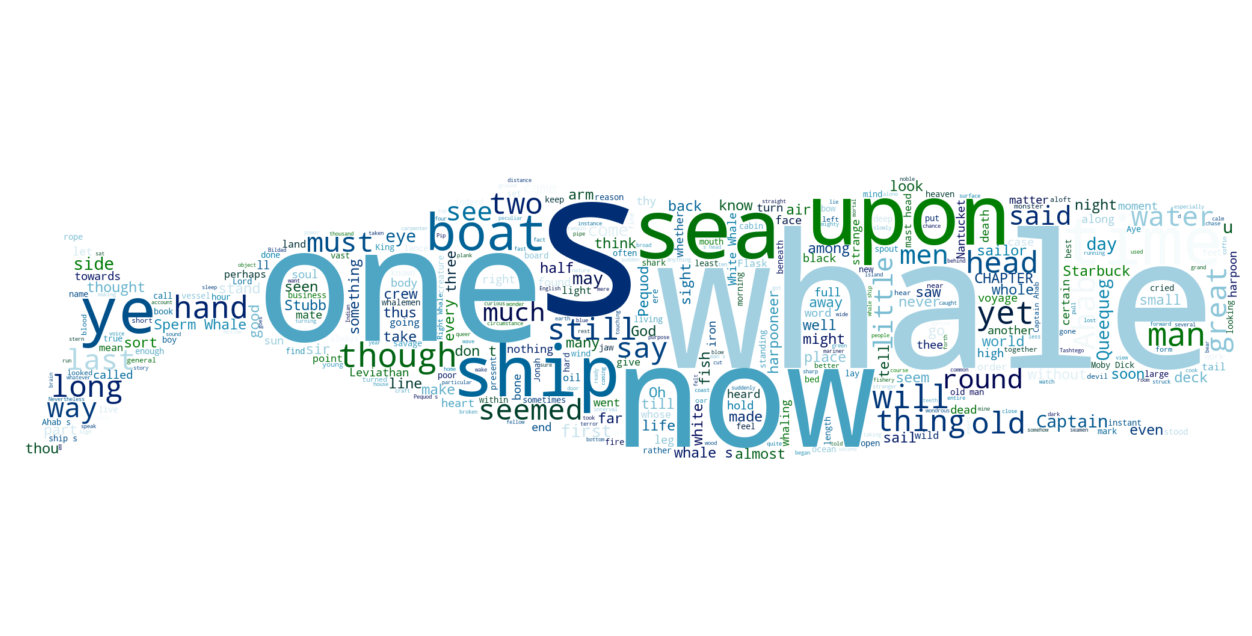

In [60]:
#Open the whale image using Image from PIL
icon = Image.open(WHALE_FILE)
# create new image object
image_mask = Image.new(mode='RGB', size=icon.size , color=(255,255,255))
# now paste the picture of whale to out new image
image_mask.paste(icon, box=icon)
rgb_array= np.array(image_mask) # convert image object to an array


word_cloud = WordCloud(mask = rgb_array , background_color='white',
                       max_words=400, colormap='ocean')
word_cloud.generate(novel_as_string)
plt.figure(figsize=[16,8])
plt.imshow(word_cloud, interpolation='bilinear')

plt.axis('off')
plt.show()

In [61]:
example_hemlet= nltk.corpus.gutenberg.words('shakespeare-hamlet.txt')
word_list_shake=[''.join(word) for word in example_hemlet]
novel_shake_as_string = ' '.join(word_list_shake)
type(novel_shake_as_string)

str

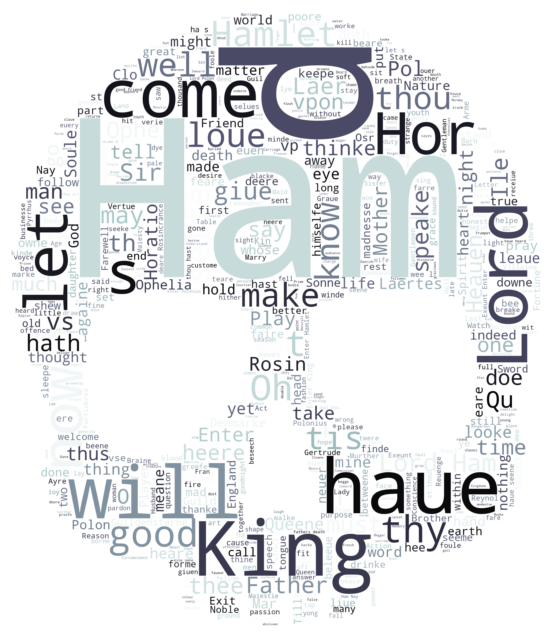

In [62]:
#for shakepear
#Open the whale image using Image from PIL
icon = Image.open(SKULL_FILE)
# create new image object
image_mask = Image.new(mode='RGB', size=icon.size , color=(255,255,255))
# now paste the picture of whale to out new image
image_mask.paste(icon, box=icon)
rgb_array= np.array(image_mask) # convert image object to an array


word_cloud = WordCloud(mask = rgb_array , background_color='white',
                       max_words=600, colormap='bone')
word_cloud.generate(novel_shake_as_string)
plt.figure(figsize=[16,8])
plt.imshow(word_cloud, interpolation='bilinear')

plt.axis('off')
plt.show()

Word cloud for HAM and SPAM messages

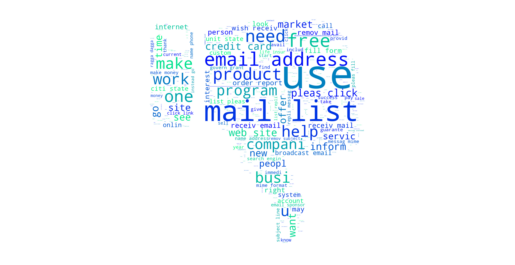

In [63]:
flat_list_ham
flat_list_spam

email_spam = ' '.join(flat_list_spam)

icon = Image.open(THUMBS_DOWN_FILE)
image_mask = Image.new(mode='RGB' , size=icon.size , color=(255,255,255))
image_mask.paste(icon , box=icon)
rgb_array= np.array(image_mask)

word_cloud = WordCloud(mask= rgb_array , background_color='white' ,max_words=400 , colormap='winter').generate(email_spam)
#plt.figure(figsize=[16,8])
plt.imshow(word_cloud , interpolation='bilinear')
plt.axis('off')
plt.show()


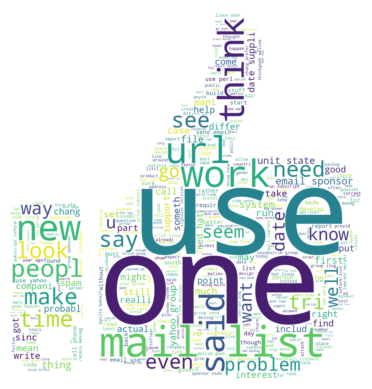

In [64]:
flat_list_ham
flat_list_spam

email_ham = ' '.join(flat_list_ham)

icon = Image.open(THUMBS_UP_FILE)
image_mask = Image.new(mode='RGB' , size=icon.size , color=(255,255,255))
image_mask.paste(icon , box=icon)
rgb_array= np.array(image_mask)

word_cloud = WordCloud(mask= rgb_array , background_color='white' ,max_words=400).generate(email_ham)
#plt.figure(figsize=[16,8])
plt.imshow(word_cloud , interpolation='bilinear')
plt.axis('off')
plt.show()

Generate Vocabulary and Dictionary

In [65]:
stemmed_nested_list = data.MESSAGE.apply(clean_message_no_html)
flat_stemmed_list = [item for sublist in stemmed_nested_list for item in sublist]

C:\Users\jasee\AppData\Local\Temp\ipykernel_1408\2089539986.py:5: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(message, 'html.parser')
C:\Users\jasee\AppData\Local\Temp\ipykernel_1408\2089539986.py:5: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  soup = BeautifulSoup(message, 'html.parser')


In [66]:
unique_words = pd.Series(flat_stemmed_list).value_counts()
print('no of unique words',len(unique_words))
#unique_words.head()
frequent_words = unique_words[0:VOCAB_SIZE]
print('most common words is \n', frequent_words[:10])

no of unique words 22875
most common words is 
 http     11721
use       5634
list      4743
get       4676
email     4466
one       4210
mail      4204
free      3479
time      3455
like      3191
Name: count, dtype: int64


Vocabalary DataFrame with a WORD_ID

In [67]:
word_id = list(range(0,VOCAB_SIZE))
vocab = pd.DataFrame({'VOCAB_WORD': frequent_words.index.values }, index=word_id)
vocab.index.name = 'WORD_ID'
vocab.head()

,VOCAB_WORD
WORD_ID,
0,http
1,use
2,list
3,get
4,email


Save the Vocabolary as a CSV file

In [68]:
vocab.to_csv(WORD_ID_FILE , index_label=vocab.index.name , header=vocab.VOCAB_WORD.name)

CHeck if a perticular word is in the vocabulary

In [69]:
ini_vocab = ['machine','learning','fun','learn','data','science','app','brewery']
listofwords =[]
for word in vocab.VOCAB_WORD:
    if word in ini_vocab:
        listofwords.append(word)

print('the list words are in this list ,\n', listofwords)
print('count is ', len(listofwords))

any(vocab.VOCAB_WORD == 'learn')
'learn' in set(vocab.VOCAB_WORD) # better way        

the list words are in this list ,
 ['data', 'learn', 'fun', 'app']
count is  4


True

Find the Longest email with the most number of words
note the longest email position in the list
print the words of longest mail. printout the email

In [70]:
# count_1 =[]
# for sublist in nested_list:
#     count =0 
#     for word in sublist:
#         count=count+1
#     count_1.append(count)
# clean_email_lengths =[]
# for sublist in stemmed_nested_list:
#     clean_email_lengths.append(len(sublist))

clean_email_lengths = [len(sublist) for sublist in stemmed_nested_list]
max_index= np.argmax(clean_email_lengths)

In [73]:
# clean_email_lengths = max(count_1)
print('the max value is \n',clean_email_lengths)
# cot=-1
# for i in count_1:
#     cot=cot+1
#     if i ==  max_value:
#         print(i)
#         print('the index is ',cot)
print(' the index of that email is ',max_index)

the max value is 
 [92, 56, 44, 206, 45, 161, 47, 162, 203, 44, 55, 23, 44, 74, 64, 235, 47, 208, 36, 56, 223, 192, 0, 93, 14, 208, 44, 18, 64, 95, 312, 56, 141, 72, 55, 1066, 48, 139, 2, 90, 78, 4, 47, 70, 44, 75, 38, 12, 38, 63, 47, 51, 71, 80, 25, 275, 36, 63, 19, 18, 14, 40, 57, 18, 77, 28, 102, 41, 226, 68, 120, 5, 52, 0, 40, 40, 208, 0, 40, 146, 62, 114, 64, 253, 1221, 49, 0, 65, 52, 145, 15, 0, 90, 70, 2, 198, 50, 50, 50, 214, 119, 43, 80, 44, 319, 243, 9, 36, 98, 26, 52, 333, 47, 42, 0, 38, 78, 97, 79, 55, 102, 34, 70, 55, 18, 129, 50, 0, 39, 74, 43, 72, 47, 80, 0, 28, 223, 97, 0, 58, 84, 214, 75, 47, 18, 104, 20, 114, 110, 187, 6, 40, 54, 79, 276, 110, 208, 6, 489, 62, 17, 175, 79, 47, 74, 82, 255, 33, 218, 38, 36, 110, 93, 61, 55, 41, 108, 80, 84, 0, 52, 1390, 108, 97, 25, 185, 1, 119, 255, 28, 137, 195, 177, 0, 98, 109, 1466, 0, 108, 150, 113, 38, 153, 38, 42, 0, 0, 383, 188, 77, 330, 14, 92, 92, 104, 372, 187, 241, 143, 254, 14, 98, 135, 223, 65, 90, 226, 217, 129, 38, 94, 

In [74]:
nested_list[2572]

['free',
 'trade',
 'free',
 'market',
 'proven',
 'abil',
 'lift',
 'whole',
 'societi',
 'poverti',
 'buff',
 'anybodi',
 'clear',
 'exampl',
 'origin',
 'messag',
 'rohit',
 'khare',
 'sent',
 'friday',
 'septemb',
 'pm',
 'subject',
 'sed',
 'world',
 'live',
 'comfort',
 'plenti',
 'half',
 'human',
 'race',
 'live',
 'less',
 'day',
 'neither',
 'stabl',
 'absolut',
 'correct',
 'perhap',
 'fundament',
 'thing',
 'realiz',
 'life',
 'earth',
 'today',
 'follow',
 'fascin',
 'document',
 'offici',
 'govern',
 'polici',
 'bear',
 'close',
 'read',
 'aspir',
 'wonder',
 'nation',
 'imperfect',
 'world',
 'war',
 'terror',
 'clash',
 'civil',
 'howev',
 'reveal',
 'clash',
 'insid',
 'civil',
 'battl',
 'futur',
 'muslim',
 'world',
 'struggl',
 'idea',
 'area',
 'america',
 'must',
 'excel',
 'recent',
 'lectur',
 'surpris',
 'success',
 'radio',
 'sawa',
 'new',
 'channel',
 'year',
 'old',
 'arab',
 'practic',
 'everi',
 'market',
 'enter',
 'near',
 'listenership',
 'amman',
 'ev

In [75]:
data.at[max_index, 'MESSAGE']

'\n\n"Free trade and free markets have proven their ability to lift whole\n\nsocieties out of poverty"\n\nI\'m not a socio-political/history buff - does anybody have some clear\n\nexamples?\n\n\n\n\n\n----- Original Message -----\n\nFrom: "Rohit Khare" <khare@alumni.caltech.edu>\n\nTo: <fork@spamassassin.taint.org>\n\nSent: Friday, September 20, 2002 5:10 PM\n\nSubject: sed /s/United States/Roman Empire/g\n\n\n\n\n\n> > A world where some live in comfort and plenty, while half of the human\n\n> > race lives on less than $2 a day, is neither just nor stable.\n\n>\n\n> Absolutely correct. Perhaps the most fundamental thing to realize about\n\n> life on Earth today.\n\n>\n\n> The following is a fascinating document of official Government policy\n\n> that bears close reading. It is the aspirations of a wonderful nation in\n\n> an imperfect world.\n\n>\n\n> >  The war on terrorism is not a clash of civilizations. It does,\n\n> > however, reveal the clash inside a civilization, a battle for 

Generate Feature and a Sparse Matrix
Creating a Dataframe with one word per column

In [76]:
type(stemmed_nested_list)

pandas.core.series.Series

In [77]:
type(stemmed_nested_list.tolist())

list

In [ ]:
stemmed_nested_list.tolist()

In [79]:
word_columns_df = pd.DataFrame.from_records(stemmed_nested_list.tolist())
word_columns_df

,0,1,2,3,4,5,6,7,8,9,...,7344,7345,7346,7347,7348,7349,7350,7351,7352,7353
0,save,life,insur,spend,life,quot,save,g,famili,financi,...,None,None,None,None,None,None,None,None,None,None
1,fight,risk,cancer,http,slim,guarante,lose,lb,day,http,...,None,None,None,None,None,None,None,None,None,None
2,fight,risk,cancer,http,slim,guarante,lose,lb,day,http,...,None,None,None,None,None,None,None,None,None,None
3,adult,club,offer,free,membership,instant,access,site,user,name,...,None,None,None,None,None,None,None,None,None,None
4,thought,might,like,slim,guarante,lose,lb,day,http,fight,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6891,man,kill,surf,tube,train,ananova,wednesday,decemb,investig,launch,...,None,None,None,None,None,None,None,None,None,None
6892,hi,gianni,good,resourc,http,http,walk,guid,umber,latop,...,None,None,None,None,None,None,None,None,None,None
6893,gianni,ponzi,wrote,prob,tri,instal,linux,tri,redhat,suse,...,None,None,None,None,None,None,None,None,None,None
6894,neal,pickett,write,skip,montanaro,write,ye,also,seem,web,...,None,None,None,None,None,None,None,None,None,None


In [82]:
pd.DataFrame.from_records([['word','hi','hello'],['my','god','what']])

,0,1,2
0,word,hi,hello
1,my,god,what


In [83]:
word_columns_df.shape

(6896, 7354)

Splitting the Data into a Training and Testing Datasets

In [84]:
X_train, X_test, y_train, y_test = train_test_split(word_columns_df,data.CATEGORY,test_size =0.3 , random_state = 42)

In [85]:
print("Nr of training sample" , X_train.shape[0])
print("fraction of training sample" , X_train.shape[0]/word_columns_df.shape[0])


Nr of training sample 4827
fraction of training sample 0.6999709976798144


In [86]:
X_train.index.name = X_test.index.name ='DOC_ID'
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,7344,7345,7346,7347,7348,7349,7350,7351,7352,7353
DOC_ID,,,,,,,,,,,,,,,,,,,,,
1294,stop,pay,adult,site,show,hot,get,free,password,free,...,None,None,None,None,None,None,None,None,None,None
6472,url,http,date,think,get,new,mac,good,reason,though,...,None,None,None,None,None,None,None,None,None,None
5792,inlin,mon,sep,justin,mason,wrote,razor,support,fulli,chang,...,None,None,None,None,None,None,None,None,None,None
6438,url,http,date,media,took,one,column,newspap,rod,liddl,...,None,None,None,None,None,None,None,None,None,None
4922,begin,forward,text,prioriti,normal,date,mon,sep,law,polici,...,None,None,None,None,None,None,None,None,None,None


In [87]:
y_train.head()

DOC_ID
1294    1
6472    0
5792    0
6438    0
4922    0
Name: CATEGORY, dtype: int64

Create a Sparse Matrix for the training data

In [88]:
word_index = pd.Index(vocab.VOCAB_WORD)
word_index.get_loc('mon')
#X_train.index[0]

677

In [89]:
def make_sparse_matrix(df, indexed_words, labels):
    nr_rows = df.shape[0]
    nr_cols = df.shape[1]
    
    word_set = set(indexed_words)
    dict_list =[]
    for i in range(nr_rows):
        for j in range(nr_cols):
           
           word = df.iat[i,j] 
           if word in word_set:
               doc_id = df.index[i]
               word_id = indexed_words.get_loc(word)
               category = labels.at[doc_id]
               
               item ={'LABEL' : category , 'DOC_ID': doc_id, 
                      'OCCURENCE':1, 'WORD_ID': word_id}
               dict_list.append(item)
                
    return pd.DataFrame(dict_list)            
                 
                
                

In [90]:
%%time
sparse_train_df = make_sparse_matrix(X_train, word_index, y_train)

CPU times: total: 8min 28s
Wall time: 8min 36s


In [102]:
sparse_train_df[:5]
sparse_train_df.shape


(479386, 4)

Combine Occurences with Pandas groupby() method

In [93]:
train_grouped = sparse_train_df.groupby(['DOC_ID','WORD_ID','LABEL']).sum()
train_grouped.head()

OCCURENCE
DOC_ID WORD_ID LABEL           
0      2       1              1
       3       1              1
       4       1              2
       7       1              3
       14      1              1

In [96]:
vocab.at[7,'VOCAB_WORD']

'free'

In [97]:
data.MESSAGE[0]

'<!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 4.0 Transitional//EN">\n\n<HTML><HEAD>\n\n<META content=3D"text/html; charset=3Dwindows-1252" http-equiv=3DContent-T=\n\nype>\n\n<META content=3D"MSHTML 5.00.2314.1000" name=3DGENERATOR></HEAD>\n\n<BODY><!-- Inserted by Calypso -->\n\n<TABLE border=3D0 cellPadding=3D0 cellSpacing=3D2 id=3D_CalyPrintHeader_ r=\n\nules=3Dnone \n\nstyle=3D"COLOR: black; DISPLAY: none" width=3D"100%">\n\n  <TBODY>\n\n  <TR>\n\n    <TD colSpan=3D3>\n\n      <HR color=3Dblack noShade SIZE=3D1>\n\n    </TD></TR></TD></TR>\n\n  <TR>\n\n    <TD colSpan=3D3>\n\n      <HR color=3Dblack noShade SIZE=3D1>\n\n    </TD></TR></TBODY></TABLE><!-- End Calypso --><!-- Inserted by Calypso=\n\n --><FONT \n\ncolor=3D#000000 face=3DVERDANA,ARIAL,HELVETICA size=3D-2><BR></FONT></TD><=\n\n/TR></TABLE><!-- End Calypso --><FONT color=3D#ff0000 \n\nface=3D"Copperplate Gothic Bold" size=3D5 PTSIZE=3D"10">\n\n<CENTER>Save up to 70% on Life Insurance.</CENTER></FONT><FONT color=3D#ff=\n\n0000

In [98]:
train_grouped = train_grouped.reset_index()
train_grouped.head()

,DOC_ID,WORD_ID,LABEL,OCCURENCE
0,0,2,1,1
1,0,3,1,1
2,0,4,1,2
3,0,7,1,3
4,0,14,1,1


In [101]:
train_grouped.tail()
vocab.at[2208,'VOCAB_WORD']

'boot'

In [103]:
train_grouped.shape

(292923, 4)

Save Train file as Txt file

In [105]:
np.savetxt(TRAINING_DATA_FILE, train_grouped, fmt='%d')

In [106]:
train_grouped.columns

Index(['DOC_ID', 'WORD_ID', 'LABEL', 'OCCURENCE'], dtype='object')

## Create the sparse matrix for the test data , group the occurences of the same word in the same email. then save the data as a .txt file

In [108]:
%%time
sparse_test_df = make_sparse_matrix(X_test, word_index, y_test)

CPU times: total: 2min 45s
Wall time: 2min 46s


In [109]:
test_grouped = sparse_test_df.groupby(['DOC_ID' , 'WORD_ID' , 'LABEL']).sum()
test_grouped = test_grouped.reset_index()

In [110]:
np.savetxt(TEST_DATA_FILE, test_grouped, fmt='%d')

Pre-Processing Subtleties
How many indivitual emails were included in the testing.txt file ? count the number in the test_grouped Dataframe. after spliting and shuffling our data, howmany emails were included in the X_test dataframe ? is the number the same ? if not, which emails were excluded and why ? comare the DOC_ID values to find out.

In [119]:
test_grouped.DOC_ID


0            8
1            8
2            8
3            8
4            8
          ... 
129080    6891
129081    6891
129082    6891
129083    6891
129084    6891
Name: DOC_ID, Length: 129085, dtype: int64

In [ ]:
testgroup=set(test_grouped.DOC_ID)
testgroup

In [130]:
set(X_test.index.values) - testgroup

{73, 91, 179, 240, 339, 439, 471, 734, 765, 940, 965, 1170, 1360, 1544, 1670}

In [134]:
data.loc[73]

MESSAGE      ------=_NextPart_000_00C2_37C70C2D.A8844B81\n\...
CATEGORY                                                     1
FILE_NAME               00074.51aab41b27a9ba7736803318a2e4c8de
Name: 73, dtype: object

In [1]:
clean_message_no_html(data.at[1170,'MESSAGE'])

NameError: name 'clean_message_no_html' is not defined